Demo on how to use `scri` to load CCE waveform data (available [here](https://data.black-holes.org/waveforms/extcce_catalog.html)) and map it to the superrest frame ([arxiv:2110.15922](https://arxiv.org/abs/2110.15922)). Note that it is recommended to install `scri` ([repo here](https://github.com/moble/scri)) via `conda`. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import qnmfits
import scri

We will work with SXS:BBH_ExtCCE:0001 (files available [here](https://zenodo.org/records/4734836)). There are files for multiple "levels" (i.e., simulation resolution, with the highest level being the highest resolution), and for each level there are multiple waveform quantities. As part of the CCE extraction procedure, a "worldtube radius" must be chosen, which is the number in the filename following the `R`. As discussed in [arxiv:2110.15922](https://arxiv.org/abs/2110.15922), it is usual to take **the second smallest worldtube radius**. For CCE:0001, this means using the `R0292` files.

To load a waveform into `scri`, you need to download data for the five Weyl scalars and the strain. So, for CCE:0001 you need to download the `.h5` and `.json` files for each of:

 - `r5Psi0OverM3_BondiCce_R0292_CoM`
 - `r4Psi1OverM2_BondiCce_R0292_CoM`
 - `r3Psi2OverM_BondiCce_R0292_CoM`
 - `r2Psi3_BondiCce_R0292_CoM`
 - `rMPsi4_BondiCce_R0292_CoM`
 - `rhOverM_BondiCce_R0292_CoM`

These are then loaded using the [`scri.SpEC.create_abd_from_h5()`](https://scri.readthedocs.io/en/latest/_autosummary/scri.SpEC.file_io.html#scri.SpEC.file_io.create_abd_from_h5) function:

In [2]:
abd = scri.SpEC.create_abd_from_h5(
    file_format='RPXMB', 
    h='rhOverM_BondiCce_R0292_CoM.h5',
    Psi4='rMPsi4_BondiCce_R0292_CoM.h5',
    Psi3='r2Psi3_BondiCce_R0292_CoM.h5',
    Psi2='r3Psi2OverM_BondiCce_R0292_CoM.h5',
    Psi1='r4Psi1OverM2_BondiCce_R0292_CoM.h5',
    Psi0='r5Psi0OverM3_BondiCce_R0292_CoM.h5'
    )

This creates an `AsymptoticBondiData` object (see the tutorial [here](https://scri.readthedocs.io/en/latest/tutorial_abd.html)). Useful remnant quantities can be accessed:

In [3]:
Mf = abd.bondi_rest_mass()[-1]
chif = abd.bondi_dimensionless_spin()[-1]

Below we provide a function to convert an `AsymptoticBondiData` object to a `WaveformModes` object containing the strain (a tutorial for `WaveformModes` is [here](https://scri.readthedocs.io/en/latest/tutorial_waveformmodes.html) - these objects are easier to work with in practice): 

In [4]:
def abd_to_h(abd):
    """
    Convert an AsymptoticBondiData object to a WaveformModes object.
    
    Parameters
    ----------
    abd : AsymptoticBondiData
        The simulation data.
    
    Returns
    -------
    h_wm : WaveformModes
        The simulation data in the WaveformModes format.
    """
    # The strain is related to the shear in the following way
    h = 2*abd.sigma.bar.ndarray.copy()

    # Convert to a WaveformModes object
    h_wm = scri.WaveformModes(
        dataType = scri.h,
        t = abd.t,
        data = h,
        ell_min=abd.ell_min, 
        ell_max=abd.ell_max,
        frameType = scri.Inertial,
        r_is_scaled_out = True,
        m_is_scaled_out = True,
    )

    return h_wm

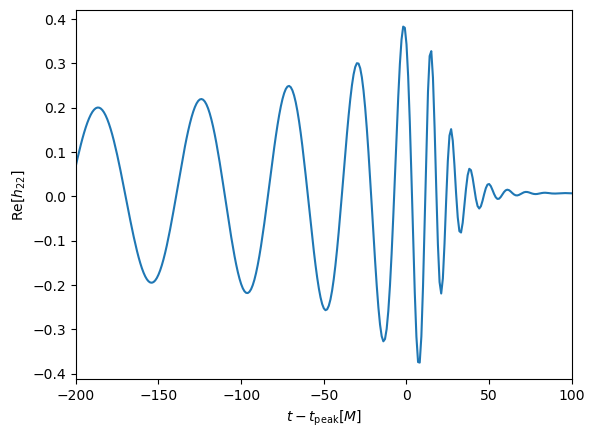

In [5]:
h = abd_to_h(abd)

# Rescale the time so that the peak of the waveform is at t=0
h.t -= h.max_norm_time()

# Plot the (2,2) mode
fig, ax = plt.subplots()

ax.plot(h.t, np.real(h.data[:, h.index(2,2)]))

ax.set_xlim(-200, 100)

ax.set_xlabel(r'$t - t_\mathrm{peak} [M]$')
_ = ax.set_ylabel(r'$\mathrm{Re}[h_{22}]$')

Mapping to the superrest frame is done via the [`map_to_superrest_frame()`](https://scri.readthedocs.io/en/latest/_autosummary/scri.asymptotic_bondi_data.map_to_superrest_frame.html#scri.asymptotic_bondi_data.map_to_superrest_frame.map_to_superrest_frame) function. A time `t_0` to apply the transformation should be chosen: **about 300M after the time of peak strain is a good choice for ringdown studies**:

In [6]:
abd_prime, transformations, err = abd.map_to_superrest_frame(t_0=300)
h_prime = abd_to_h(abd_prime)

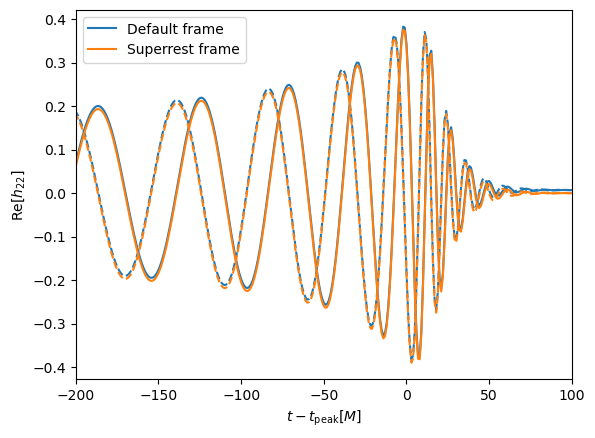

In [7]:
fig, ax = plt.subplots()

ax.plot(h.t, np.real(h.data[:, h.index(2,2)]), c='C0', label='Default frame')
ax.plot(h.t, np.imag(h.data[:, h.index(2,2)]), '--', c='C0')

ax.plot(h_prime.t, np.real(h_prime.data[:, h_prime.index(2,2)]), c='C1', label='Superrest frame')
ax.plot(h_prime.t, np.imag(h_prime.data[:, h_prime.index(2,2)]), '--', c='C1')

ax.set_xlim(-200, 100)

ax.legend()

ax.set_xlabel(r'$t - t_\mathrm{peak} [M]$')
_ = ax.set_ylabel(r'$\mathrm{Re}[h_{22}]$')

To start doing fits with the `qnmfits` package, we just need to convert the `h_prime` `WaveformModes` object into a Python dictionary:

In [8]:
h_prime_dict = {'times': h_prime.t}
for ell in range(2, h.ell_max+1):
    for m in range(-ell,ell+1):
        h_prime_dict[ell,m] = np.array(h_prime.data[:, h.index(ell,m)])

# It is probably a good idea to save this so you don't have to re-do the 
# transformation
import pickle
with open('SXS:BBH_ExctCCE:0001_superrest.pkl', 'wb') as f:
    pickle.dump(h_prime_dict, f)

In [9]:
# Define the zero time to be at the peak of the (2,2) mode
zero_time = h_prime_dict['times'][np.argmax(abs(h_prime_dict[2,2]))]
h_prime_dict['times'] -= zero_time

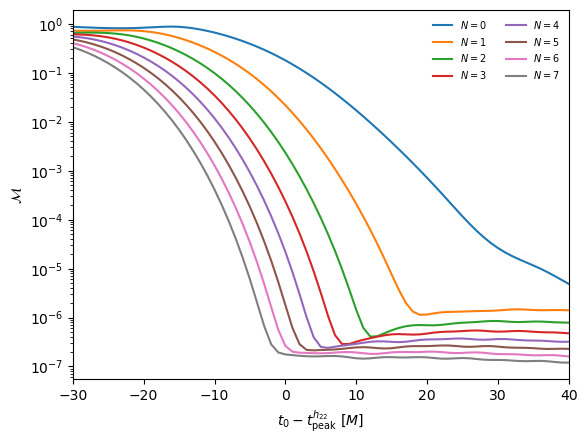

In [10]:
# We will fit to the (2,2) spherical-harmonic mode, with the following
# combinations of modes:
mode_list = [[(2,2,n,1) for n in range(N)] for N in range(1,7+2)]

# The start times to use. Note that CCE waveforms have a lower time resolution
# than the extrapolated waveforms.
t0_array = np.linspace(-30, 40, 71)

# Create figure
fig, ax = plt.subplots(dpi=100)

for modes in mode_list:
    
    # Create mismatch list
    mm_list = qnmfits.mismatch_t0_array(
        h_prime_dict['times'],
        h_prime_dict[2,2],
        modes,
        Mf=Mf,
        chif=np.linalg.norm(chif),
        t0_array=t0_array,
        t0_method='closest'
    )
    
    # Add to figure
    ax.semilogy(t0_array, mm_list, label=f'$N = {modes[-1][-2]}$')
    
# Plot limits and labels
ax.set_xlim(t0_array[0], t0_array[-1])
ax.set_xlabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
ax.set_ylabel('$\mathcal{M}$')

_ = ax.legend(ncol=2, frameon=False, fontsize=7)

This plot can be compared to the similar one in the [example notebook](https://github.com/eliotfinch/qnmfits/blob/main/examples/package_tutorial.ipynb). Notice that at late times the mismatch does not rise, since now our waveform decays to zero properly.

It is also possible to initialise a `Custom` waveform class to hold the CCE data:

In [11]:
# Remove the times entry from the h_prime dictionary
times = h_prime_dict.pop('times')

sim = qnmfits.Custom(
    times, 
    h_prime_dict, 
    metadata={'remnant_mass':Mf, 'remnant_dimensionless_spin':chif}, 
    zero_time=(2,2)
    )

The `sim` object behaves more like the SXS class, which includes shifting the time for you, and pre-computing things like the spin magnitude and waveform derivatives. To create the same figure as above you now do:

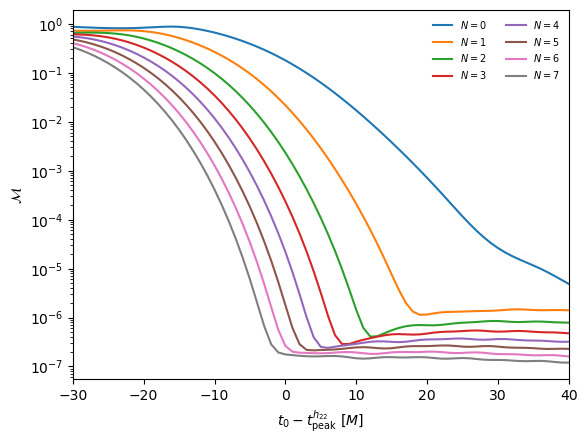

In [12]:
# Create figure
fig, ax = plt.subplots(dpi=100)

for modes in mode_list:
    
    # Create mismatch list
    mm_list = qnmfits.mismatch_t0_array(
        sim.times,
        sim.h[2,2],
        modes,
        Mf=sim.Mf,
        chif=sim.chif_mag,
        t0_array=t0_array,
        t0_method='closest'
    )
    
    # Add to figure
    ax.semilogy(t0_array, mm_list, label=f'$N = {modes[-1][-2]}$')
    
# Plot limits and labels
ax.set_xlim(t0_array[0], t0_array[-1])
ax.set_xlabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
ax.set_ylabel('$\mathcal{M}$')

_ = ax.legend(ncol=2, frameon=False, fontsize=7)